In [1]:
!pip install 'h5py==2.10.0'

In [2]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week4()

--2022-03-03 19:36:50--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2022-03-03 19:36:50 (47.5 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [3]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Denoising Autoencoders And Where To Find Them

train deep autoencoders and apply them to faces and similar images search. subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [4]:
import sys
sys.path.append("..")
import grading

In [5]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
from keras_utils import reset_tf_session

Using TensorFlow backend.


# Load dataset
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [7]:
# we downloaded them for you, just link them here
download_utils.link_week_4_resources()

In [8]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

**************************************************



In [9]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1384

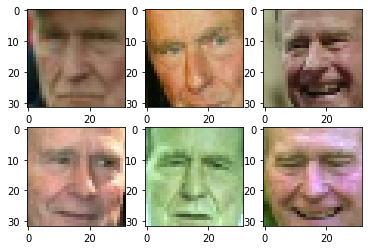

In [10]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architecture

Design autoencoder as two sequential keras models: the encoder and decoder respectively.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/autoencoder.png?raw=1" style="width:50%">

# First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/pca.png?raw=1" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [11]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Define a linear autoencoder as described above.
    Flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [12]:
import os
os.environ["EXPERIMENTAL_TQDM"] = "1"

In [13]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/15


0it [00:00, ?it/s]


Epoch 2/15


0it [00:00, ?it/s]


Epoch 3/15


0it [00:00, ?it/s]


Epoch 4/15


0it [00:00, ?it/s]


Epoch 5/15


0it [00:00, ?it/s]


Epoch 6/15


0it [00:00, ?it/s]


Epoch 7/15


0it [00:00, ?it/s]


Epoch 8/15


0it [00:00, ?it/s]


Epoch 9/15


0it [00:00, ?it/s]


Epoch 10/15


0it [00:00, ?it/s]


Epoch 11/15


0it [00:00, ?it/s]


Epoch 12/15


0it [00:00, ?it/s]


Epoch 13/15


0it [00:00, ?it/s]


Epoch 14/15


0it [00:00, ?it/s]


Epoch 15/15


0it [00:00, ?it/s]

In [14]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006662727106617544


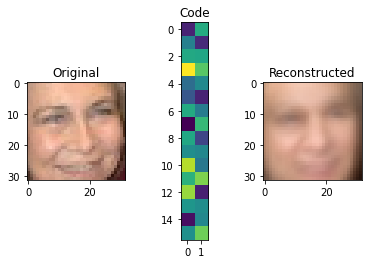

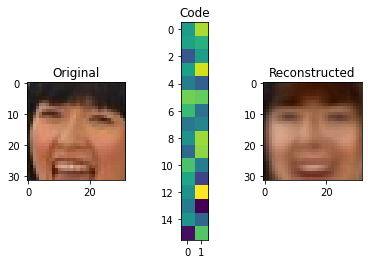

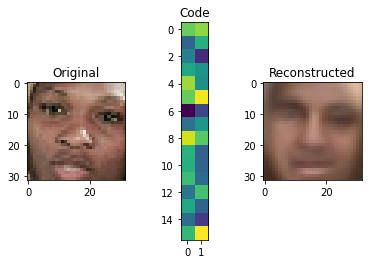

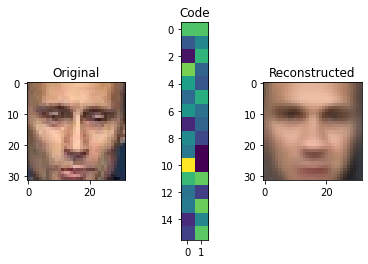

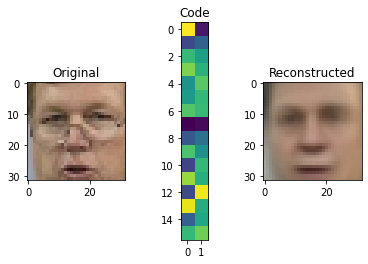

In [15]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# Going deeper: convolutional autoencoder

Build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part: stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`), using `activation='elu'` for all convolutional and dense layers.

Repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Flatten (`L.Flatten()`) output before adding the last dense layer

## Decoder

Use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). This layer "undo" convolutions in encoder.

Here's how "transpose convolution" works:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/transpose_conv.jpg?raw=1" style="width:60%">

In [16]:
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    s = reset_tf_session()
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    result = s.run(conv)
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(result[0, :, :, 0])
    s.close()
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]]
Transpose convolution test for img_size=4, filter_size=3:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter

In [17]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation='elu'))
    encoder.add(L.MaxPooling2D((2, 2)))
    encoder.add(L.Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation='elu'))
    encoder.add(L.MaxPooling2D((2, 2)))
    encoder.add(L.Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation='elu'))
    encoder.add(L.MaxPooling2D((2, 2)))
    encoder.add(L.Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation='elu'))
    encoder.add(L.MaxPooling2D((2, 2)))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    
    decoder.add(L.Dense(2*2*256))                 #actual encoder 
    decoder.add(L.Reshape((2,2,256)))         #un-flatten
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [18]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()


Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [19]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [20]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [21]:
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None


# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [22]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           keras_utils.TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)


Epoch 1/25


0it [00:00, ?it/s]

Model saved in autoencoder.000.hdf5

Epoch 2/25


0it [00:00, ?it/s]

Model saved in autoencoder.001.hdf5

Epoch 3/25


0it [00:00, ?it/s]

Model saved in autoencoder.002.hdf5

Epoch 4/25


0it [00:00, ?it/s]

Model saved in autoencoder.003.hdf5

Epoch 5/25


0it [00:00, ?it/s]

Model saved in autoencoder.004.hdf5

Epoch 6/25


0it [00:00, ?it/s]

Model saved in autoencoder.005.hdf5

Epoch 7/25


0it [00:00, ?it/s]

Model saved in autoencoder.006.hdf5

Epoch 8/25


0it [00:00, ?it/s]

Model saved in autoencoder.007.hdf5

Epoch 9/25


0it [00:00, ?it/s]

Model saved in autoencoder.008.hdf5

Epoch 10/25


0it [00:00, ?it/s]

Model saved in autoencoder.009.hdf5

Epoch 11/25


0it [00:00, ?it/s]

Model saved in autoencoder.010.hdf5

Epoch 12/25


0it [00:00, ?it/s]

Model saved in autoencoder.011.hdf5

Epoch 13/25


0it [00:00, ?it/s]

Model saved in autoencoder.012.hdf5

Epoch 14/25


0it [00:00, ?it/s]

Model saved in autoencoder.013.hdf5

Epoch 15/25


0it [00:00, ?it/s]

Model saved in autoencoder.014.hdf5

Epoch 16/25


0it [00:00, ?it/s]

Model saved in autoencoder.015.hdf5

Epoch 17/25


0it [00:00, ?it/s]

Model saved in autoencoder.016.hdf5

Epoch 18/25


0it [00:00, ?it/s]

Model saved in autoencoder.017.hdf5

Epoch 19/25


0it [00:00, ?it/s]

Model saved in autoencoder.018.hdf5

Epoch 20/25


0it [00:00, ?it/s]

Model saved in autoencoder.019.hdf5

Epoch 21/25


0it [00:00, ?it/s]

Model saved in autoencoder.020.hdf5

Epoch 22/25


0it [00:00, ?it/s]

Model saved in autoencoder.021.hdf5

Epoch 23/25


0it [00:00, ?it/s]

Model saved in autoencoder.022.hdf5

Epoch 24/25


0it [00:00, ?it/s]

Model saved in autoencoder.023.hdf5

Epoch 25/25


0it [00:00, ?it/s]

Model saved in autoencoder.024.hdf5


Convolutional autoencoder MSE: 0.005484609601898792


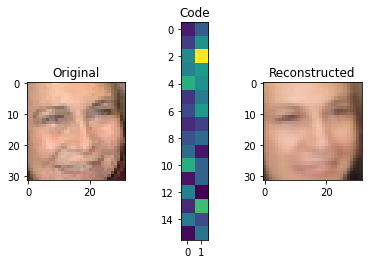

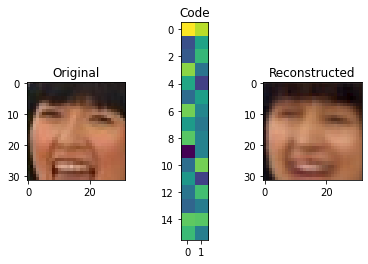

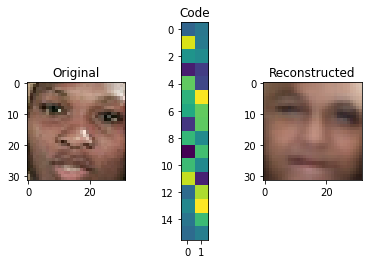

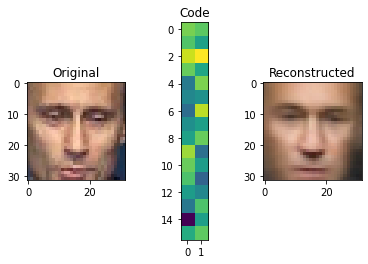

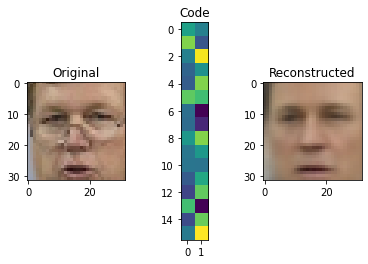

In [23]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [24]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [25]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005484609579235428
0.005484609601898792


# Denoising Autoencoder

Let's now turn our model into a denoising autoencoder

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/denoising.jpg?raw=1" style="width:40%">

Strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. 

In [27]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(0, sigma, X.shape)
    return X + noise

In [28]:
# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

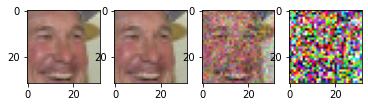

In [29]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Training will take **1 hour**.

In [30]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 2/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 3/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 4/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 5/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 6/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 7/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 8/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 9/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 10/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 11/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 12/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 13/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 14/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 15/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 16/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 17/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 18/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 19/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 20/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 21/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 22/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 23/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 24/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Epoch 25/25, Generating corrupted samples...

Epoch 1/1


0it [00:00, ?it/s]

Denoising MSE: 0.002759688774552267


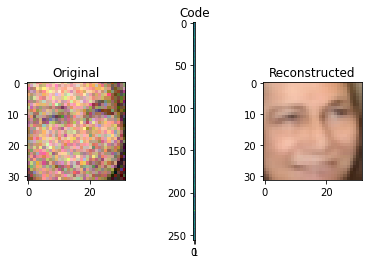

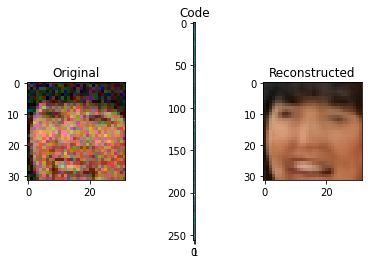

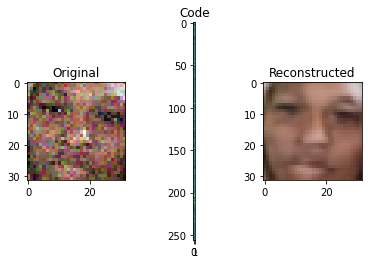

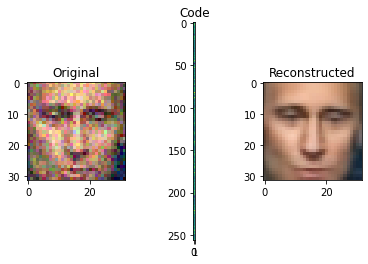

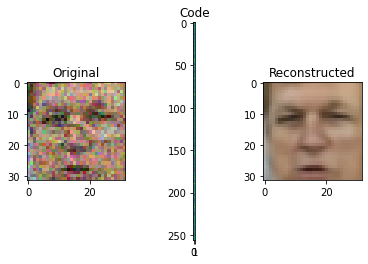

In [31]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Image retrieval with autoencoders

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/similar_images.jpg?raw=1" style="width:60%">

To speed up retrieval process, use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). caclulate nearest neighbours in brute force way for simplicity.

In [32]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [33]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [35]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [36]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [37]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

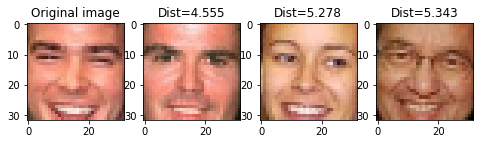

In [38]:
# smiles
show_similar(X_test[247])

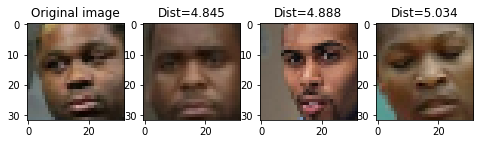

In [39]:
# ethnicity
show_similar(X_test[56])

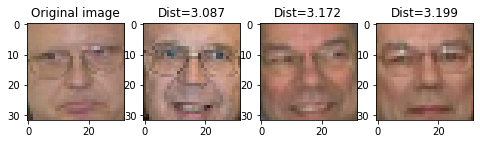

In [40]:
# glasses
show_similar(X_test[63])

# Cheap image morphing
take linear combinations of image codes to produce new images with decoder.

In [41]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

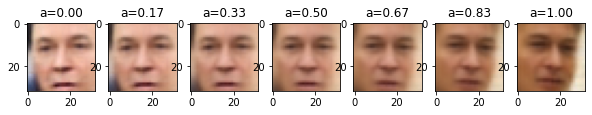

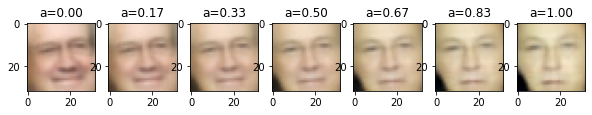

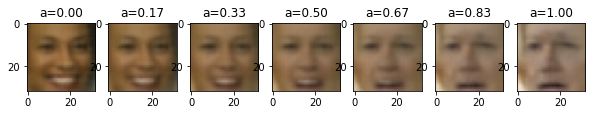

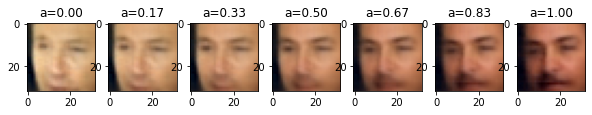

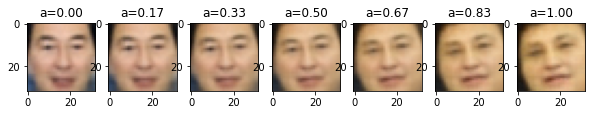

In [42]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()